In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [ ]:
import cartopy.crs as ccrs 
import cmocean # only with GEOMAR 

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm # only with ipykernel

In [3]:
dataset=(r'/Users/chiaraciscato/Desktop/geomar/FOCI data/CO2flux_baseline_ensemble1_ssp126_1m.nc')
data = xr.open_dataset(dataset)

In [4]:
y = data.variables['nav_lat'][:]
x = data.variables['nav_lon'][:]
time = data.variables['time_counter'][:]
co2flux = data.variables['co2flux_cpl'][:].squeeze()

In [5]:
# calculate the month length 

month_length = data.time_counter.dt.days_in_month 
month_length 

<xarray.DataArray 'days_in_month' (time_counter: 1020)>
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...

In [6]:
# calculate the weights by grouping by season

weights = (month_length.groupby("time_counter.season") / month_length.groupby("time_counter.season").sum())

In [7]:
# test that the sum of the weights for each season is 1.0

np.testing.assert_allclose(weights.groupby('time_counter.season').sum().values, np.ones(4))

In [8]:
# divide the dataframe by seasons

ds_weighted = data.groupby('time_counter.season').mean('time_counter')

In [18]:
# select season -winter-

ds_winter = ds_weighted.sel(season='DJF')

In [19]:
# select season -summer-

ds_summer = ds_weighted.sel(season='JJA')

In [20]:
# select season -spring-

ds_spring = ds_weighted.sel(season='MAM')

In [21]:
# select season -autumn-

ds_autumn = ds_weighted.sel(season='SON')

In [22]:
ds_unweighted = data.groupby("time_counter.season").mean("time_counter")
ds_diff = ds_weighted - ds_unweighted
ds_diff

<xarray.Dataset>
Dimensions:      (y: 511, x: 722, season: 4)
Coordinates:
    nav_lat      (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.07 50.0 50.0
    nav_lon      (y, x) float32 72.75 73.25 73.75 74.25 ... 73.01 73.0 73.0
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: y, x
Data variables:
    co2flux_cpl  (season, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Text(0.5, 1.02, 'Seasonal Average of CO2 flux')

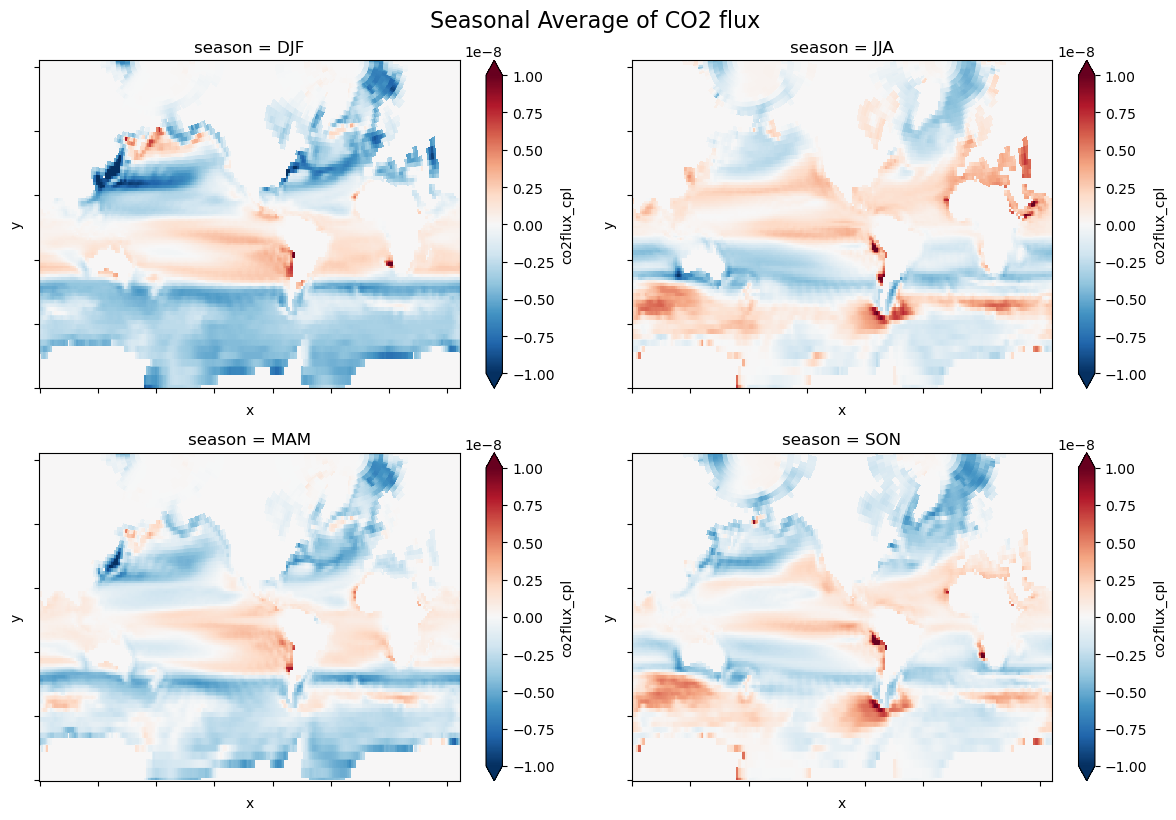

In [10]:
ds_season = data.co2flux_cpl.groupby('time_counter.season').mean('time_counter')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
i = 0
for j, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if season =='JJA':
        i += 1
        j = 0
        
    elif season =='SON':
        j = 1
        
    ds_season.sel(season=season).plot.pcolormesh(
        ax=axes[j, i], vmin=-0.00000001, vmax=0.00000001, cmap='RdBu_r',
        add_colorbar=True, extend='both')
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')

plt.tight_layout()
fig.suptitle('Seasonal Average of CO2 flux', fontsize=16, y=1.02)

In [24]:
# last seven days of the simulation

ds = '/Users/chiaraciscato/Desktop/geomar/FOCI data/CO2flux_baseline_ensemble1_ssp126_1m.nc'

cmap = cmocean.cm.thermal
with xr.open_dataset(ds) as xadf:
    pd = xadf.isel(time_counter=slice(-5,None), y=slice(300, 500), x=slice(400, 700)) #last seven days
    facet = pd['co2flux_cpl'].plot(x='x', y='y', col='time_counter',col_wrap=5,robust=True,figsize=(16,2.5),cmap=cmap)

NameError: name 'cmocean' is not defined

In [ ]:
# incomplete

seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))

In [ ]:
ds_season.plot(col='season', col_wrap=2, figsize=(10, 6))
plt.suptitle("Seasonal Average of CO2 flux", y=1.05)

In [11]:
ds_season_df = ds_season.to_dataframe()

In [17]:
# https://stackoverflow.com/questions/41818927/how-to-subset-data-using-multidimensional-coordinates-using-python-xarray

sliced_data = data.where((-25 < data.nav_lon) & (data.nav_lon < 20) & (35 < data.nav_lat) & (data.nav_lat < 70), drop=True)

In [29]:
sliced_df = sliced_data.to_dataframe()
sliced_df

time_centered_bounds  \
time_counter        axis_nbounds y   x                         
2015-01-16 12:00:00 0            0   0                   NaT   
                                     1            2015-01-01   
                                     2            2015-01-01   
                                     3            2015-01-01   
                                     4            2015-01-01   
...                                                      ...   
2099-12-16 12:00:00 1            119 86                  NaT   
                                     87                  NaT   
                                     88                  NaT   
                                     89                  NaT   
                                     90                  NaT   

                                        time_counter_bounds   co2flux_cpl  \
time_counter        axis_nbounds y   x                                      
2015-01-16 12:00:00 0            0   0                  NaT           NaN   
                                     1           2015-01-01 -1.956602e-09   
                                     2           2015-01-01 -1.956602e-09   
                                     3           2015-01-01 -1.956602e-09   
                                     4           2015-01-01 -1.585093e-09   
...                                                     ...           ...   
2099-12-16 12:00:00 1            119 86                 NaT           NaN   
                                     87                 NaT           NaN   
                                     88                 NaT           NaN   
                                     89                 NaT           NaN   
                                     90                 NaT           NaN   

                                           nav_lat    nav_lon  \
time_counter        axis_nbounds y   x                          
2015-01-16 12:00:00 0            0   0   35.129448 -25.242975   
                                     1   35.128761 -24.741835   
                                     2   35.127968 -24.240690   
                                     3   35.127068 -23.739544   
                                     4   35.126060 -23.238394   
...                                            ...        ...   
2099-12-16 12:00:00 1            119 86  65.728882  34.173565   
                                     87  65.564896  34.621044   
                                     88  65.400185  35.064079   
                                     89  65.234779  35.502747   
                                     90  65.068687  35.937126   

                                              time_centered  
time_counter        axis_nbounds y   x                       
2015-01-16 12:00:00 0            0   0  2015-01-16 12:00:00  
                                     1  2015-01-16 12:00:00  
                                     2  2015-01-16 12:00:00  
                                     3  2015-01-16 12:00:00  
                                     4  2015-01-16 12:00:00  
...                                                     ...  
2099-12-16 12:00:00 1            119 86 2099-12-16 12:00:00  
                                     87 2099-12-16 12:00:00  
                                     88 2099-12-16 12:00:00  
                                     89 2099-12-16 12:00:00  
                                     90 2099-12-16 12:00:00  

[22276800 rows x 6 columns]

In [ ]:
# seasonal average over time
# https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/summarize-climate-data-by-season/

In [ ]:
# slice last 10 years

start_date = "2090-01-01"
end_date = "2100-01-01"

co2_flux = data["co2flux_cpl"].sel(time_counter=slice(start_date, end_date))

In [ ]:
# seasonal average

co2flux_season_summary = co2_flux.groupby('time_counter.season').mean('time_counter', skipna=True)

In [12]:
# resample the data by season across all years, where ‘QS-DEC’: quarterly, starting on Dec 1

co2flux_season_all = co2_flux.resample(time_counter='QS-DEC', keep_attrs=True).mean()

/opt/anaconda3/envs/GEOMAR/lib/python3.7/site-packages/xarray/core/common.py:1128: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  "Passing ``keep_attrs`` to ``resample`` has no effect and will raise an"


In [13]:
# summarise each array into one single (mean) value 

co2flux_seasonal_mean = co2flux_season_all.groupby('time_counter').mean(["y", "x"])

In [14]:
# one single (mean) value for each season

co2flux_seasonal_mean.shape

(41,)

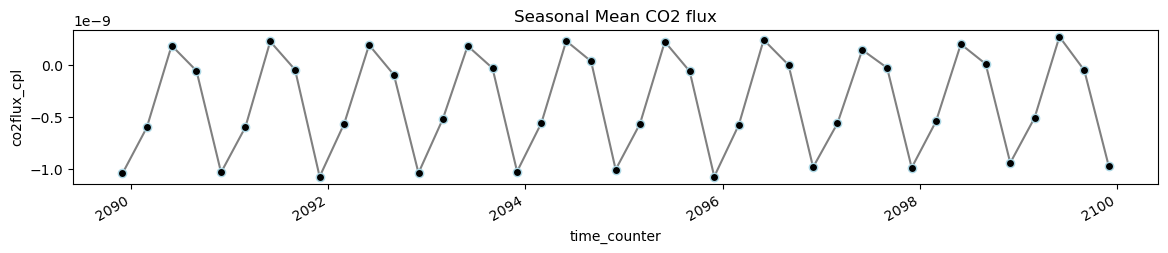

In [18]:
f, ax = plt.subplots(figsize=(14, 2))
co2flux_seasonal_mean.plot(marker="o",
                        color="grey",
                        markerfacecolor="black",
                        markeredgecolor="lightblue")
ax.set(title="Seasonal Mean CO2 flux")
plt.show()

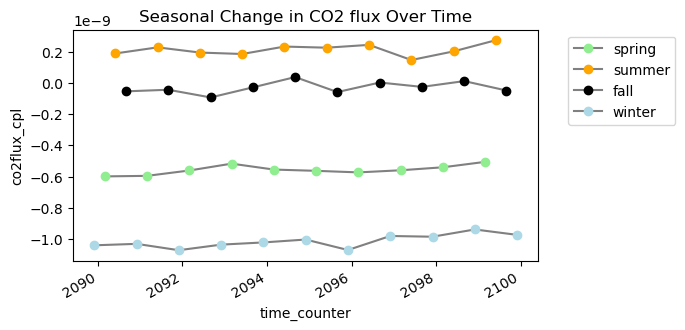

In [43]:
colors = {3: "lightgreen", 6: "orange", 9: "black", 12: "lightblue"}
seasons = {3: "spring", 6: "summer", 9: "fall", 12: "winter"}

f, ax = plt.subplots(figsize=(6, 3))
for month, arr in co2flux_seasonal_mean.groupby('time_counter.month'):
    arr.plot(ax=ax,
             color="grey",
             marker="o",
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(title="Seasonal Change in CO2 flux Over Time")
plt.show()

In [20]:
df = sliced_data.sel(time_counter=slice('2080', '2090'))
ds = df.to_dataframe()

In [28]:
# https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot

january = sliced_df.loc[(sliced_df.time_counter_bounds.dt.month==1)]

NameError: name 'sliced_df' is not defined

In [ ]:
# gca stands for 'get current axis'

ax = plt.gca()

february.plot(kind='line',x='time_counter_bnds',y='co2flux_cpl',ax=ax)

plt.show()